Does SpliceAI detect an exon creation event in STAT3 if a known splice-altering variant is applied to the input sequence? 
[https://www.pnas.org/doi/full/10.1073/pnas.1901409116](https://www.pnas.org/doi/full/10.1073/pnas.1901409116)
* Reference transcript: ENST00000264657.9
* Variant: c.1282-89C>T
* Genomic coordinates: chr17:42326288
* Used [https://genebe.net/tools/hgvs](https://genebe.net/tools/hgvs) to get the genomic coordinates from the HGVS notation

In [2]:

%load_ext autoreload
%autoreload 2
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import zarr
from pyfaidx import Fasta
from Bio.Seq import reverse_complement
from spliceai.utils import one_hot_encode
import tensorflow as tf
import os
os.chdir("/zata/zippy/ramirezc/splice-model-benchmark")
weights_path = "reference_files/spliceai/models/spliceai{index}.h5"

2025-04-30 20:29:43.660347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746059384.080300 2528460 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746059384.188308 2528460 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746059384.915002 2528460 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746059384.915042 2528460 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746059384.915045 2528460 computation_placer.cc:177] computation placer alr

In [3]:
zarr_root = zarr.group(store=zarr.DirectoryStore("results/spliceai_predictions.zarr"))
acceptor_predictions = zarr_root.require_group('acceptor_predictions')
donor_predictions = zarr_root.require_group('donor_predictions')

In [ ]:
sns.set_style("whitegrid")
sns.set_context(
    font_scale=1,
    rc={
        "font.size": 14,
        "axes.titlesize": 18,
        "axes.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16,
        }
)

plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

colors = sns.color_palette("Set2").as_hex()
colors2 = sns.color_palette("husl").as_hex()

sc = 1.8
chromosome = 'chr1'
window_start = 160681000
window_end = 160686000
window_length = window_end - window_start

fig, ax = plt.subplots(figsize=(8 * sc, 2 * sc))

for n, (feature_zarray, feature_label) in enumerate([(donor_predictions, 'donor'), (acceptor_predictions, 'acceptor')]):
    prob_dist = feature_zarray[chromosome][window_start - 1:window_end - 1]
        
    id_color = colors[n]
    ax.plot(
        prob_dist,
        color=id_color,
        label=feature_label,
        linestyle="-",
        linewidth=1.5,
    )

ax.set_xlim(0, window_length)
ax.grid(False)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.set_ylim(0, 1.05)
ax.set_ylabel("Probability")
ax.set_xlabel("Nucleotides")
ax.legend(loc="upper left", bbox_to_anchor=(1.005, 1), borderaxespad=0)

ax.set_title(f"SpliceAI Acceptor and Donor Probabilities over {chromosome}:{window_start}-{window_end}", fontweight="bold")

plt.tight_layout()
plt.show()

In [ ]:
window_length = 5000
context_length = 10000
total_length = window_length + context_length
half_total = total_length // 2
chromosome = 'chr17'
position = 42326288
window_start = position - half_total
window_end = position + half_total
window_mutation_position = position - window_start
fasta = Fasta('reference_files/GCA_000001405.15_GRCh38_no_alt_analysis_set.fasta')
window_list = list(fasta[chromosome][window_start:window_end].seq)
print(window_list[window_mutation_position])
# window_list[window_mutation_position] = 'T'
# print(window_list[window_mutation_position])
window = reverse_complement("".join(window_list))


models = []
for idx in range(1, 6):
    model = tf.keras.models.load_model(weights_path.format(index=idx), compile=False)
    models.append(model)
    
# print(models[0].summary())

X = one_hot_encode(window)[None, :]
# y = np.mean([models[m].predict(X) for m in range(5)], axis=0)
y = np.mean(models[1].predict(X), axis=0) # 1 and 4?
print(y.shape)

# acceptor_prob = y[0, :, 1][::-1] # Reverse the array back to the original orientation
# donor_prob = y[0, :, 2][::-1]
acceptor_prob = y[:, 1][::-1] # Reverse the array back to the original orientation
donor_prob = y[:, 2][::-1]

print(acceptor_prob[:20])
print(donor_prob[:20])

C
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(5000, 3)
[1.68260534e-08 3.42535280e-08 5.81318318e-06 9.72556968e-09
 5.74054027e-10 1.58698121e-08 8.67689067e-08 6.61164989e-08
 1.14136665e-08 1.05063984e-08 2.84636958e-09 2.88608746e-08
 3.82793797e-09 1.93753067e-08 5.34874474e-08 4.85444218e-09
 3.87907164e-08 4.54098714e-09 3.18028341e-08 2.02771169e-08]
[5.7267016e-08 7.6043790e-08 3.9435506e-07 1.7887002e-08 1.1954106e-07
 2.3588157e-08 8.8156114e-09 3.9291052e-07 1.8226582e-07 6.7843860e-07
 1.7252931e-07 1.1253322e-07 4.3450267e-08 4.5296235e-07 4.3587977e-07
 4.0782421e-08 3.9477200e-07 1.9233508e-07 3.1009364e-07 9.8731971e-07]


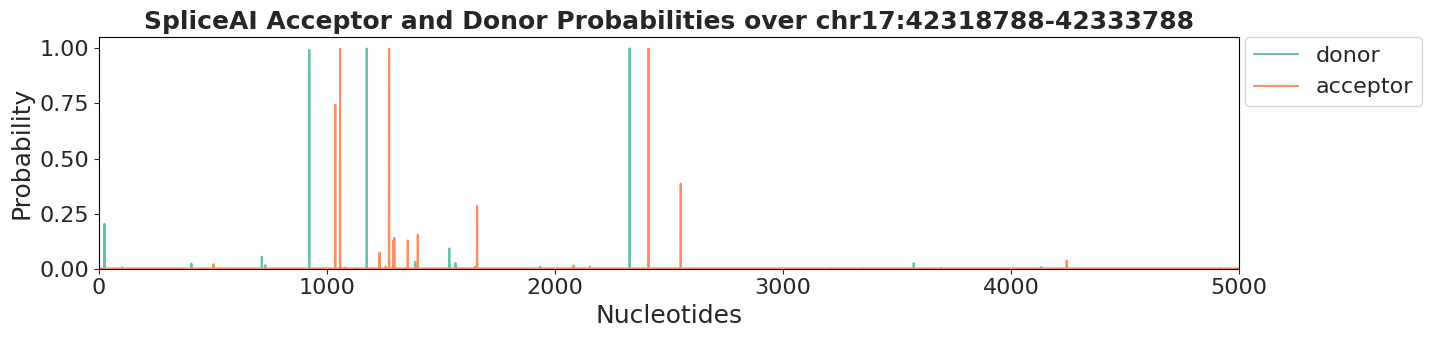

In [15]:
sns.set_style("whitegrid")
sns.set_context(
    font_scale=1,
    rc={
        "font.size": 14,
        "axes.titlesize": 18,
        "axes.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16,
        }
)

plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

colors = sns.color_palette("Set2").as_hex()
colors2 = sns.color_palette("husl").as_hex()

sc = 1.8

fig, ax = plt.subplots(figsize=(8 * sc, 2 * sc))

for n, (prob_dist, feature_label) in enumerate([(donor_prob, 'donor'), (acceptor_prob, 'acceptor')]):
    id_color = colors[n]
    ax.plot(
        prob_dist,
        color=id_color,
        label=feature_label,
        linestyle="-",
        linewidth=1.5,
    )

ax.set_xlim(0, window_length)
ax.grid(False)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.set_ylim(0, 1.05)
ax.set_ylabel("Probability")
ax.set_xlabel("Nucleotides")
ax.legend(loc="upper left", bbox_to_anchor=(1.005, 1), borderaxespad=0)

ax.set_title(f"SpliceAI Acceptor and Donor Probabilities over {chromosome}:{window_start}-{window_end}", fontweight="bold")
# ax.text(1.005, 0.60, f"chr17:42326288C>T", fontsize=14, transform=ax.transAxes)

plt.tight_layout()
plt.savefig(f"results/spliceai_predictions_{chromosome}_{window_start}_{window_end}.svg", dpi=300, format='svg')
plt.show()